In [2]:
import pickle
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import os

from collections import deque
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, RepeatVector, LSTM, Dense, Lambda, TimeDistributed
from tensorflow.keras import losses, metrics, activations
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
import seaborn as sns

In [3]:
split = pickle.load(open('./final_data_ST_120_2019.pkl', 'rb'))['ST4000DM000']
file_list = os.listdir('./ST4000DM000')
train_list = split['train']
val_list = split['val']
test_list = split['test']
col = ['smart_7_raw', 'smart_9_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw', 'until_fail_days']
timestep_list = [5, 10, 20, 30]

### Min-Max Scaler

In [4]:
scaler_path = './scaler_anomaly_detection.pkl'
if not os.path.isfile(scaler_path):
    scaler = MinMaxScaler()
    min_value, max_value, min_scale, max_scale = [], [], [], []
    for file_name in file_list:
        db = pickle.load(open(f'./ST4000DM000/{file_name}', 'rb'))[col[:-1]]
        each_min = db.min(axis=0)
        each_max = db.max(axis=0)
        min_value.append(each_min)
        max_value.append(each_max)
    min_scale.append(np.array(min_value).min(axis=0))
    max_scale.append(np.array(max_value).max(axis=0))
    scaler.fit([min_scale[0], max_scale[0]])
    pickle.dump(scaler, open(scaler_path, 'wb'))
else:
    scaler = pickle.load(open(scaler_path, 'rb'))

### Data Configuration (Time_step = 120)

In [5]:
db_path = './Processed_DB/db_120.pkl'
if not os.path.isfile(db_path):
    db_zip_120 = {f'{t}': {'train':[], 'val':[], 'test':[]} for t in timestep_list}
    for file_name in file_list:
        db = pickle.load(open(f'./ST4000DM000/{file_name}', 'rb'))
        db = db[db['until_fail_days']>120][col[:-1]]
        for t in timestep_list:
            if len(db) >= t:
                scaled_db = scaler.transform(db)
                if file_name[:-4] in train_list:
                    db_zip_120[f'{t}']['train'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                elif file_name[:-4] in val_list:
                    db_zip_120[f'{t}']['val'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                elif file_name[:-4] in test_list:
                    db_zip_120[f'{t}']['test'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                    
    for t in timestep_list:
        db_zip_120[f'{t}']['train'] = np.concatenate(db_zip_120[f'{t}']['train'])
        db_zip_120[f'{t}']['val'] = np.concatenate(db_zip_120[f'{t}']['val'])
        db_zip_120[f'{t}']['test'] = np.concatenate(db_zip_120[f'{t}']['test'])
    pickle.dump(db_zip_120, open(db_path, 'wb'))
else:
    db_zip_120 = pickle.load(open(db_path, 'rb'))

### Data Configuration (Time_step = 60)

In [6]:
db_path = './Processed_DB/db_60.pkl'
if not os.path.isfile(db_path):
    db_zip_60 = {f'{t}': {'train':[], 'val':[], 'test':[]} for t in timestep_list}
    for file_name in file_list:
        db = pickle.load(open(f'./ST4000DM000/{file_name}', 'rb'))
        db = db[db['until_fail_days']>60][col[:-1]]
        for t in timestep_list:
            if len(db) >= t:
                scaled_db = scaler.transform(db)
                if file_name[:-4] in train_list:
                    db_zip_60[f'{t}']['train'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                elif file_name[:-4] in val_list:
                    db_zip_60[f'{t}']['val'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                elif file_name[:-4] in test_list:
                    db_zip_60[f'{t}']['test'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                    
    for t in timestep_list:
        db_zip_60[f'{t}']['train'] = np.concatenate(db_zip_60[f'{t}']['train'])
        db_zip_60[f'{t}']['val'] = np.concatenate(db_zip_60[f'{t}']['val'])
        db_zip_60[f'{t}']['test'] = np.concatenate(db_zip_60[f'{t}']['test'])
    pickle.dump(db_zip_60, open(db_path, 'wb'))
else:
    db_zip_60 = pickle.load(open(db_path, 'rb'))

### Data Configuration (Time_step=30)

In [11]:
db_path = './Processed_DB/db_30.pkl'
if not os.path.isfile(db_path):
    db_zip_30 = {f'{t}': {'train':[], 'val':[], 'test':[]} for t in timestep_list}
    for file_name in file_list:
        db = pickle.load(open(f'./ST4000DM000/{file_name}', 'rb'))
        db = db[db['until_fail_days']>30][col[:-1]]
        for t in timestep_list:
            if len(db) >= t:
                scaled_db = scaler.transform(db)
                if file_name[:-4] in train_list:
                    db_zip_30[f'{t}']['train'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                elif file_name[:-4] in val_list:
                    db_zip_30[f'{t}']['val'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                elif file_name[:-4] in test_list:
                    db_zip_30[f'{t}']['test'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                    
    for t in timestep_list:
        db_zip_30[f'{t}']['train'] = np.concatenate(db_zip_30[f'{t}']['train'])
        db_zip_30[f'{t}']['val'] = np.concatenate(db_zip_30[f'{t}']['val'])
        db_zip_30[f'{t}']['test'] = np.concatenate(db_zip_30[f'{t}']['test'])
    pickle.dump(db_zip_30, open(db_path, 'wb'))
else:
    db_zip_30 = pickle.load(open(db_path, 'rb'))

c:\Program Files\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\Program Files\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\Program Files\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\Program Files\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\Program Files\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\Program Files\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\P

### Model Configuration

In [7]:
def flatten(X):
    '''
    Flatten a 3D array.

    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.

    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1] - 1), :]
    return (flattened_X)

In [8]:
def lstm_ae(db, n_dimensions):
    time_step, input_dim = db.shape[1], db.shape[2]
    inputs = Input(shape=(time_step, input_dim))
    encoded = LSTM(n_dimensions, return_sequences=True, name="encoder_01")(inputs)
    encoded = LSTM(int(n_dimensions/2), return_sequences=False, name="encoder_02")(encoded)
    decoded = RepeatVector(time_step)(encoded)
    decoded = LSTM(int(input_dim/2), return_sequences=True, name='decoder_01')(decoded)
    decoded = LSTM(n_dimensions, return_sequences=True, name='decoder_02')(decoded)
    output = TimeDistributed(Dense(input_dim))(decoded)


    autoencoder = Model(inputs, output)
    autoencoder.compile(optimizer='adam', loss='mse', metrics=['cosine_proximity'])
    autoencoder.summary()
    return autoencoder

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 5, 5)]            0         
                                                                 
 encoder_01 (LSTM)           (None, 5, 256)            268288    
                                                                 
 encoder_02 (LSTM)           (None, 128)               197120    
                                                                 
 repeat_vector_12 (RepeatVec  (None, 5, 128)           0         
 tor)                                                            
                                                                 
 decoder_01 (LSTM)           (None, 5, 2)              1048      
                                                                 
 decoder_02 (LSTM)           (None, 5, 256)            265216    
                                                          

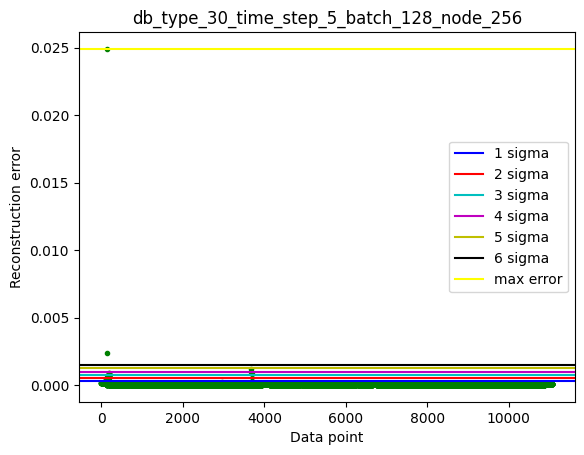

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 10, 5)]           0         
                                                                 
 encoder_01 (LSTM)           (None, 10, 256)           268288    
                                                                 
 encoder_02 (LSTM)           (None, 128)               197120    
                                                                 
 repeat_vector_13 (RepeatVec  (None, 10, 128)          0         
 tor)                                                            
                                                                 
 decoder_01 (LSTM)           (None, 10, 2)             1048      
                                                                 
 decoder_02 (LSTM)           (None, 10, 256)           265216    
                                                          

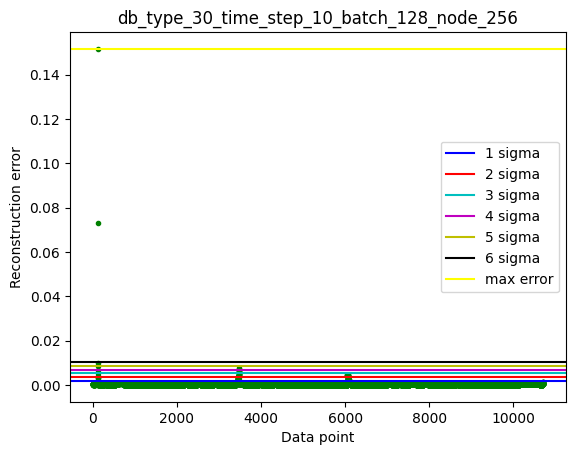

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 20, 5)]           0         
                                                                 
 encoder_01 (LSTM)           (None, 20, 256)           268288    
                                                                 
 encoder_02 (LSTM)           (None, 128)               197120    
                                                                 
 repeat_vector_14 (RepeatVec  (None, 20, 128)          0         
 tor)                                                            
                                                                 
 decoder_01 (LSTM)           (None, 20, 2)             1048      
                                                                 
 decoder_02 (LSTM)           (None, 20, 256)           265216    
                                                          

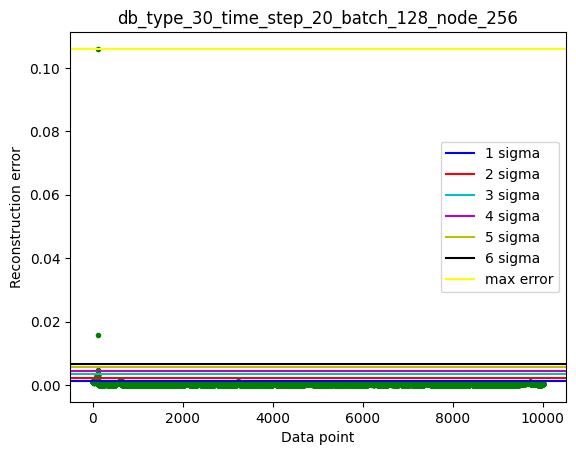

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 30, 5)]           0         
                                                                 
 encoder_01 (LSTM)           (None, 30, 256)           268288    
                                                                 
 encoder_02 (LSTM)           (None, 128)               197120    
                                                                 
 repeat_vector_15 (RepeatVec  (None, 30, 128)          0         
 tor)                                                            
                                                                 
 decoder_01 (LSTM)           (None, 30, 2)             1048      
                                                                 
 decoder_02 (LSTM)           (None, 30, 256)           265216    
                                                          

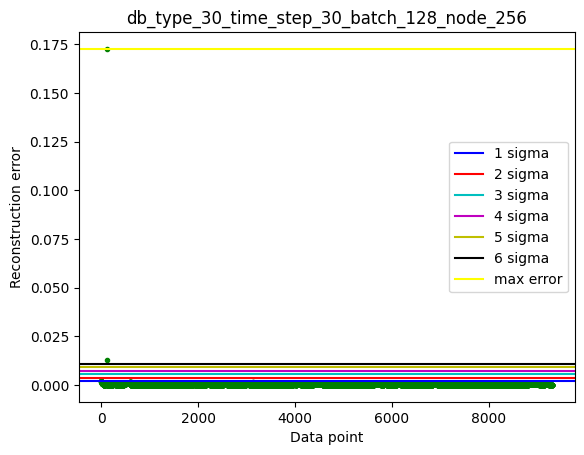

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 5, 5)]            0         
                                                                 
 encoder_01 (LSTM)           (None, 5, 256)            268288    
                                                                 
 encoder_02 (LSTM)           (None, 128)               197120    
                                                                 
 repeat_vector_16 (RepeatVec  (None, 5, 128)           0         
 tor)                                                            
                                                                 
 decoder_01 (LSTM)           (None, 5, 2)              1048      
                                                                 
 decoder_02 (LSTM)           (None, 5, 256)            265216    
                                                          

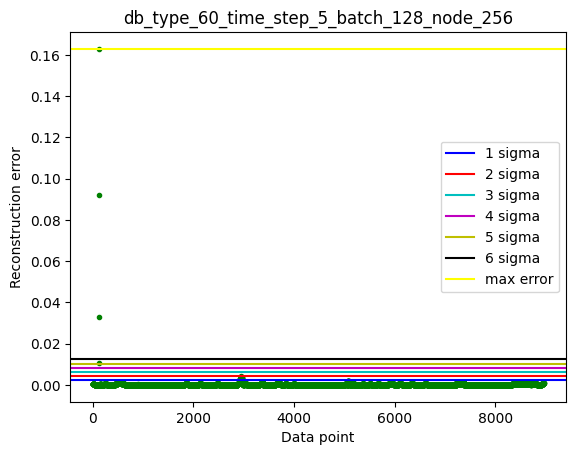

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 10, 5)]           0         
                                                                 
 encoder_01 (LSTM)           (None, 10, 256)           268288    
                                                                 
 encoder_02 (LSTM)           (None, 128)               197120    
                                                                 
 repeat_vector_17 (RepeatVec  (None, 10, 128)          0         
 tor)                                                            
                                                                 
 decoder_01 (LSTM)           (None, 10, 2)             1048      
                                                                 
 decoder_02 (LSTM)           (None, 10, 256)           265216    
                                                          

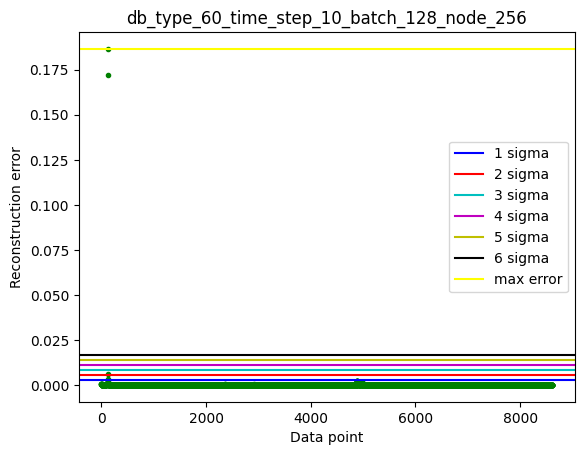

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 20, 5)]           0         
                                                                 
 encoder_01 (LSTM)           (None, 20, 256)           268288    
                                                                 
 encoder_02 (LSTM)           (None, 128)               197120    
                                                                 
 repeat_vector_18 (RepeatVec  (None, 20, 128)          0         
 tor)                                                            
                                                                 
 decoder_01 (LSTM)           (None, 20, 2)             1048      
                                                                 
 decoder_02 (LSTM)           (None, 20, 256)           265216    
                                                          

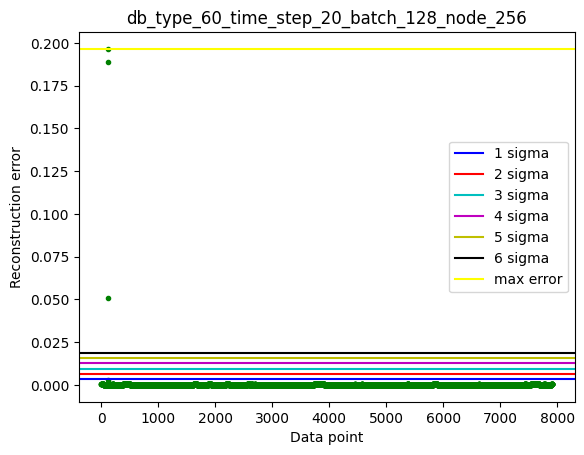

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 30, 5)]           0         
                                                                 
 encoder_01 (LSTM)           (None, 30, 256)           268288    
                                                                 
 encoder_02 (LSTM)           (None, 128)               197120    
                                                                 
 repeat_vector_19 (RepeatVec  (None, 30, 128)          0         
 tor)                                                            
                                                                 
 decoder_01 (LSTM)           (None, 30, 2)             1048      
                                                                 
 decoder_02 (LSTM)           (None, 30, 256)           265216    
                                                          

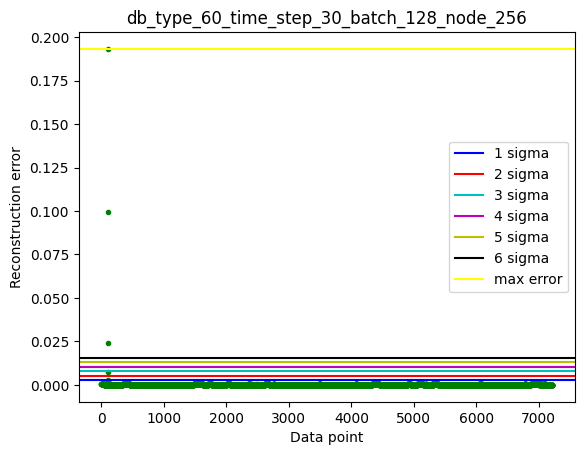

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 5, 5)]            0         
                                                                 
 encoder_01 (LSTM)           (None, 5, 256)            268288    
                                                                 
 encoder_02 (LSTM)           (None, 128)               197120    
                                                                 
 repeat_vector_20 (RepeatVec  (None, 5, 128)           0         
 tor)                                                            
                                                                 
 decoder_01 (LSTM)           (None, 5, 2)              1048      
                                                                 
 decoder_02 (LSTM)           (None, 5, 256)            265216    
                                                          

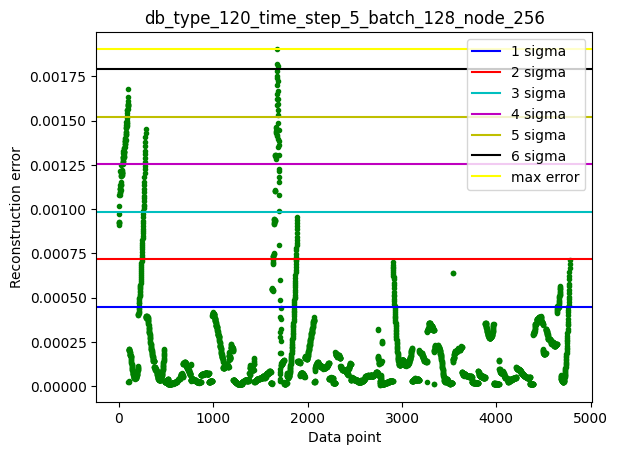

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 10, 5)]           0         
                                                                 
 encoder_01 (LSTM)           (None, 10, 256)           268288    
                                                                 
 encoder_02 (LSTM)           (None, 128)               197120    
                                                                 
 repeat_vector_21 (RepeatVec  (None, 10, 128)          0         
 tor)                                                            
                                                                 
 decoder_01 (LSTM)           (None, 10, 2)             1048      
                                                                 
 decoder_02 (LSTM)           (None, 10, 256)           265216    
                                                          

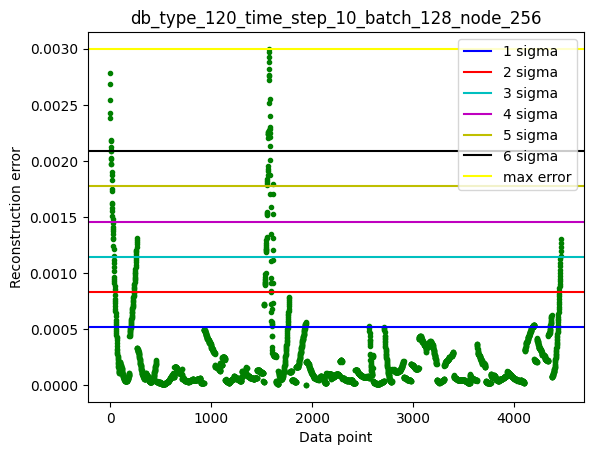

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 20, 5)]           0         
                                                                 
 encoder_01 (LSTM)           (None, 20, 256)           268288    
                                                                 
 encoder_02 (LSTM)           (None, 128)               197120    
                                                                 
 repeat_vector_22 (RepeatVec  (None, 20, 128)          0         
 tor)                                                            
                                                                 
 decoder_01 (LSTM)           (None, 20, 2)             1048      
                                                                 
 decoder_02 (LSTM)           (None, 20, 256)           265216    
                                                          

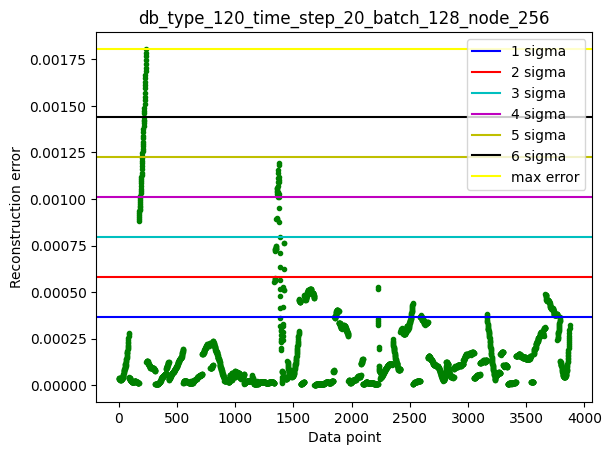

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 30, 5)]           0         
                                                                 
 encoder_01 (LSTM)           (None, 30, 256)           268288    
                                                                 
 encoder_02 (LSTM)           (None, 128)               197120    
                                                                 
 repeat_vector_23 (RepeatVec  (None, 30, 128)          0         
 tor)                                                            
                                                                 
 decoder_01 (LSTM)           (None, 30, 2)             1048      
                                                                 
 decoder_02 (LSTM)           (None, 30, 256)           265216    
                                                          

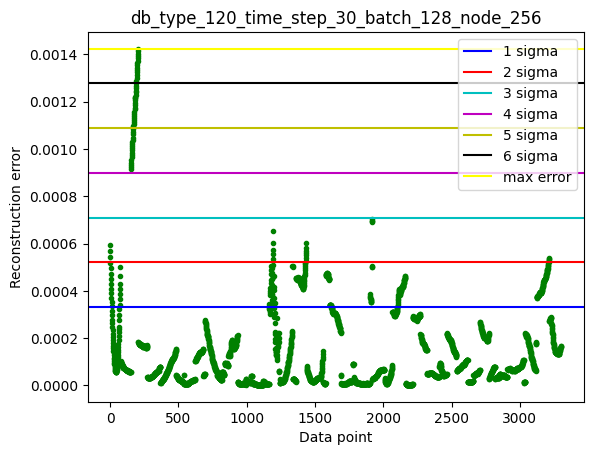

In [30]:
db_type = [30, 60, 120]
# db_type = [30]
epoch = 500
batch_size = 128
n_dimensions = 256

for temp in db_type:
    if temp == 60:
        db = db_zip_60
    elif temp == 120:
        db = db_zip_120
    elif temp == 30:
        db = db_zip_30
        
    for time_step in timestep_list:
        save_file_name = f'db_type_{temp}_time_step_{time_step}_batch_{batch_size}_node_{n_dimensions}.h5'
        db_path = f"./Model/{save_file_name[:-3]}"
        if not os.path.exists(db_path):
            os.mkdir(db_path)

        callback = EarlyStopping(monitor='val_loss', patience=30, mode='min')
        mc = ModelCheckpoint(f'{db_path}/{save_file_name}', monitor='val_loss', mode='min', save_best_only=True)

        model = lstm_ae(db=db[f'{time_step}']['train'], n_dimensions=n_dimensions)
        history = model.fit(x=db[f'{time_step}']['train'], y=db[f'{time_step}']['train'], validation_data=(db[f'{time_step}']['val'], db[f'{time_step}']['val']), epochs=epoch, batch_size=batch_size, callbacks=[callback, mc])
        pickle.dump(history.history, open(f'{db_path}/history.pkl', 'wb'))
        
        
        threshold = {}
        train_pred = model.predict(db[f'{time_step}']['train'])
        mse = np.mean(np.power(flatten(db[f'{time_step}']['train']) - flatten(train_pred), 2), axis=1)
        error = pd.DataFrame({'reconstruction_error': mse, })
        temp_ = error.describe()
        for sigma in range(1,7,1):
            threshold[sigma] = (temp_.iloc[1].values) + (sigma * (temp_.iloc[2].values))
        threshold['max'] = max(mse)

        plt.plot(mse, 'g.')
        plt.axhline(threshold[1], color='b', label='1 sigma')
        plt.axhline(threshold[2], color='r', label='2 sigma')
        plt.axhline(threshold[3], color='c', label='3 sigma')
        plt.axhline(threshold[4], color='m', label='4 sigma')
        plt.axhline(threshold[5], color='y', label='5 sigma')
        plt.axhline(threshold[6], color='k', label='6 sigma')
        plt.axhline(threshold['max'], color='yellow', label='max error')

        plt.xlabel('Data point')
        plt.ylabel('Reconstruction error')
        plt.title(f'db_type_{temp}_time_step_{time_step}_batch_{batch_size}_node_{n_dimensions}')
        plt.legend()
        plt.savefig(f'{db_path}/db_type_{temp}_time_step_{time_step}_batch_{batch_size}_node_{n_dimensions}.png')
        pickle.dump(threshold, open(f'{db_path}/threshold.pkl', 'wb'))
        plt.show()

## Evaluation

In [31]:
test_db_120 = {f'{t}': {'x':[], 'y':[]} for t in timestep_list}
for test_file_name in test_list:
    db = pickle.load(open(f'./ST4000DM000/{test_file_name}.pkl', 'rb'))
    scaled_db = scaler.transform(db[col[:-1]])
    for t in timestep_list:
        for line in range(0, len(scaled_db)-t+1):
            test_db_120[f'{t}']['x'].append(scaled_db[line:line+t])
            if db.iloc[line+t-1]['until_fail_days'] > 120:
                test_db_120[f'{t}']['y'].append(0)
            else:
                test_db_120[f'{t}']['y'].append(1)

test_db_60 = {f'{t}': {'x':[], 'y':[]} for t in timestep_list}
for test_file_name in test_list:
    db = pickle.load(open(f'./ST4000DM000/{test_file_name}.pkl', 'rb'))
    scaled_db = scaler.transform(db[col[:-1]])
    for t in timestep_list:
        for line in range(0, len(scaled_db)-t+1):
            test_db_60[f'{t}']['x'].append(scaled_db[line:line+t])
            if db.iloc[line+t-1]['until_fail_days'] > 60:
                test_db_60[f'{t}']['y'].append(0)
            else:
                test_db_60[f'{t}']['y'].append(1)
                
test_db_30 = {f'{t}': {'x':[], 'y':[]} for t in timestep_list}
for test_file_name in test_list:
    db = pickle.load(open(f'./ST4000DM000/{test_file_name}.pkl', 'rb'))
    scaled_db = scaler.transform(db[col[:-1]])
    for t in timestep_list:
        for line in range(0, len(scaled_db)-t+1):
            test_db_30[f'{t}']['x'].append(scaled_db[line:line+t])
            if db.iloc[line+t-1]['until_fail_days'] > 30:
                test_db_30[f'{t}']['y'].append(0)
            else:
                test_db_30[f'{t}']['y'].append(1)

c:\Program Files\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\Program Files\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\Program Files\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\Program Files\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\Program Files\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\Program Files\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\P

In [32]:
model_folder = os.listdir('./Model')
result = {f'{num}':{} for num in range(len(model_folder))}
for num, folder in enumerate(model_folder):
    for i in os.listdir(f'./Model/{folder}'):
        if i[-2:] == 'h5':
            model = tf.keras.models.load_model(f'./Model/{folder}/{i}')
            if folder.split('_')[2] == '60':
                db = test_db_60
            elif folder.split('_')[2] == '120':
                db = test_db_120
            elif folder.split('_')[2] == '30':
                db = test_db_30
            t = int(folder.split('_')[5])
            
            print(f'db_type: {folder.split("_")[2]}, time_step: {t}, node: {folder.split("_")[-1]}')
            print(f'Max_RE: {pickle.load(open(f"./Model/{folder}/threshold.pkl", "rb"))["max"]}')
            
            test_pred = model.predict(np.array(db[f'{t}']['x']))
            mse = np.mean(np.power(flatten(np.array(db[f'{t}']['x'])) - flatten(test_pred), 2), axis=1)
            error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': db[f'{t}']['y']})
            
            normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
            fraud_error_df = error_df[error_df['true_class'] == 1]
            
            fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
            roc_auc = auc(fpr, tpr)
            precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
            
            J = tpr - fpr
            ix = np.argmax(J)
            best_thresh = thresholds[ix]
            print(f"AUC: {roc_auc}")
            print(f"best_threshold: {best_thresh}")
            
            result[f'{num}']['db_type'] = folder.split("_")[2]
            result[f'{num}']['time_step'] = t
            result[f'{num}']['node'] = folder.split("_")[-1]
            result[f'{num}']['AUC'] = roc_auc
            result[f'{num}']['Max_RE'] = pickle.load(open(f"./Model/{folder}/threshold.pkl", "rb"))["max"]
            result[f'{num}']['best_threshold'] = best_thresh

            # groups = error_df.groupby('true_class')
            # fig, ax = plt.subplots()

            # for name, group in groups:
            #     ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            #             label= "Failure" if name == 1 else "Normal")
            # ax.hlines(best_thresh, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
            # ax.legend()
            # plt.title("Reconstruction error for different classes")
            # plt.ylabel("Reconstruction error")
            # plt.xlabel("Data point index")
            # plt.show();
            
            # LABELS = ["Normal", "Failure"]
            # y_pred = [1 if e > best_thresh else 0 for e in error_df.reconstruction_error.values]
            # conf_matrix = confusion_matrix(error_df.true_class, y_pred)
            # plt.figure(figsize=(12, 12))
            # sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
            # plt.title("Confusion matrix")
            # plt.ylabel('True class')
            # plt.xlabel('Predicted class')
            # plt.show()
            
pd.DataFrame(result).T.to_excel('./result.xlsx')

db_type: 120, time_step: 10, node: 128
Max_RE: 0.0012065383164642166
AUC: 0.5343366404334076
best_threshold: 0.00039641342358045985
db_type: 120, time_step: 10, node: 256
Max_RE: 0.0029985650759172845
AUC: 0.5981774788457366
best_threshold: 0.00019546229555025994
db_type: 120, time_step: 10, node: 32
Max_RE: 0.0030080134925367093
AUC: 0.5258815098259664
best_threshold: 0.0007567009239679577
db_type: 120, time_step: 10, node: 64
Max_RE: 0.0025301649884528375
AUC: 0.5827991347626843
best_threshold: 0.00025600401122526757
db_type: 120, time_step: 20, node: 128
Max_RE: 0.0030322718654950155
AUC: 0.5380922641463918
best_threshold: 0.0005032072534955868
db_type: 120, time_step: 20, node: 256
Max_RE: 0.0018054024663218433
AUC: 0.5675255507517134
best_threshold: 0.00020844903658172564
db_type: 120, time_step: 20, node: 32
Max_RE: 0.006757777506597032
AUC: 0.6044933941958985
best_threshold: 0.0005800884306506884
db_type: 120, time_step: 20, node: 64
Max_RE: 0.0017195759187751847
AUC: 0.54770411

In [33]:
pd.DataFrame(result).T

,db_type,time_step,node,AUC,Max_RE,best_threshold
0,120,10,128,0.534337,0.001207,0.000396
1,120,10,256,0.598177,0.002999,0.000195
2,120,10,32,0.525882,0.003008,0.000757
3,120,10,64,0.582799,0.00253,0.000256
4,120,20,128,0.538092,0.003032,0.000503
5,120,20,256,0.567526,0.001805,0.000208
6,120,20,32,0.604493,0.006758,0.00058
7,120,20,64,0.547704,0.00172,0.000476
8,120,30,128,0.608688,0.004203,0.000313
9,120,30,256,0.593789,0.001423,0.000417


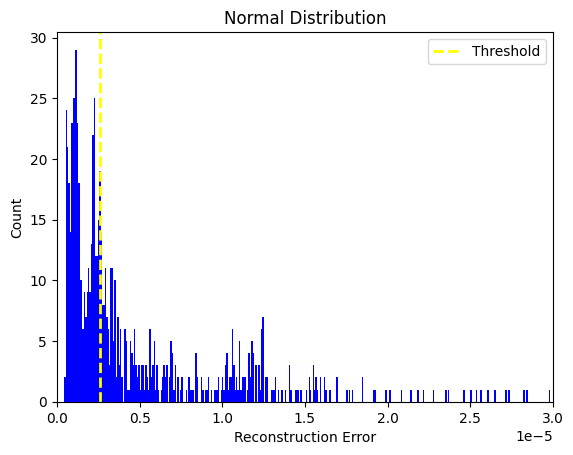

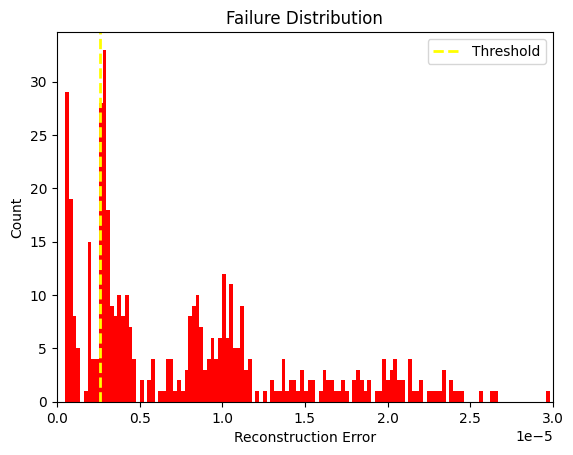

In [68]:
# test_db_type = [60, 120]

model = tf.keras.models.load_model('./Model/db_type_60_time_step_20_batch_128_node_128/db_type_60_time_step_20_batch_128_node_128.h5')

# for temp in test_db_type:
for temp in [60]:
    if temp == 60:
        db = test_db_60
    elif temp == 120:
        db = test_db_120

    # for t in timestep_list:
    for t in [20]:
        test_pred = model.predict(np.array(db[f'{t}']['x']))
        mse = np.mean(np.power(flatten(np.array(db[f'{t}']['x'])) - flatten(test_pred), 2), axis=1)
        error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': db[f'{t}']['y']})
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
        _ = ax.hist(normal_error_df.reconstruction_error.values, bins=10000, color='blue')
        _ = ax.axvline(2.60575908394076E-06, color='yellow', linestyle='--', linewidth=2, label='Threshold')
        _ = ax.set_xlim(0, 0.00003)
        _ = ax.set_xlabel('Reconstruction Error')
        _ = ax.set_ylabel('Count')
        _ = ax.set_title('Normal Distribution')
        _ = ax.legend()
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        fraud_error_df = error_df[error_df['true_class'] == 1]
        _ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10000, color='red')
        _ = ax.axvline(2.60575908394076E-06, color='yellow', linestyle='--', linewidth=2, label='Threshold')
        _ = ax.set_xlim(0, 0.00003)
        _ = ax.set_xlabel('Reconstruction Error')
        _ = ax.set_ylabel('Count')
        _ = ax.set_title('Failure Distribution')
        _ = ax.legend()

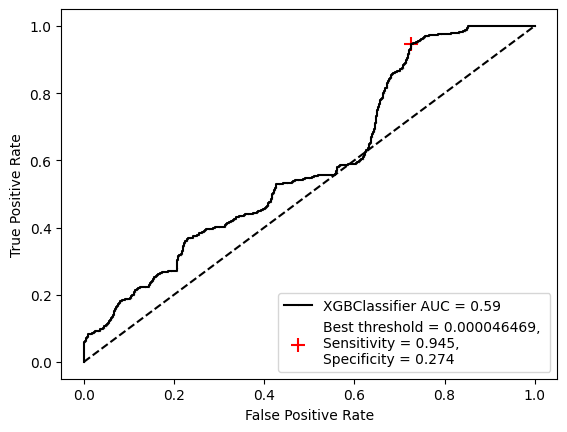

In [56]:
#plot roc and best threshold
sens, spec = tpr[ix], 1-fpr[ix]
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr, tpr, marker='.', color='black', markersize=0.05, label="XGBClassifier AUC = %.2f" % roc_auc)
plt.scatter(fpr[ix], tpr[ix], marker='+', s=100, color='r', 
            label='Best threshold = %.9f, \nSensitivity = %.3f, \nSpecificity = %.3f' % (best_thresh, sens, spec))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

# show the plot
plt.show()

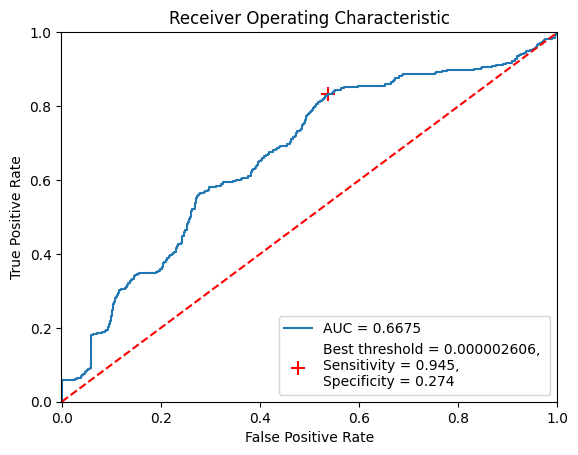

0.6674820418335671


In [75]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.scatter(fpr[ix], tpr[ix], marker='+', s=100, color='r', 
            label='Best threshold = %.9f, \nSensitivity = %.3f, \nSpecificity = %.3f' % (best_thresh, sens, spec))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();
print(roc_auc)

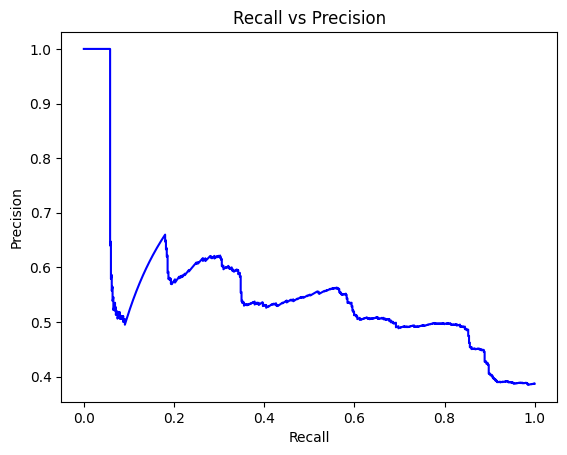

In [76]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

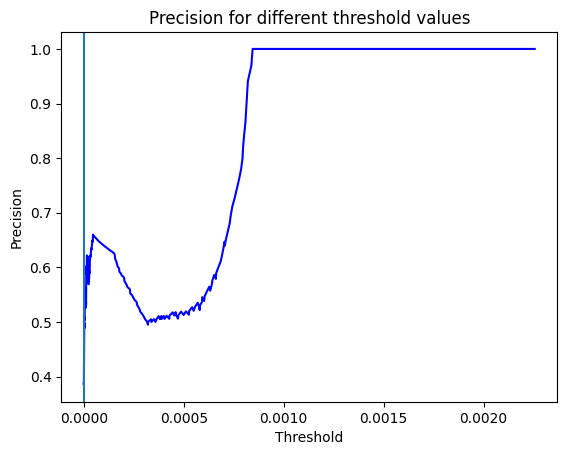

In [87]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.axvline(best_thresh)
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

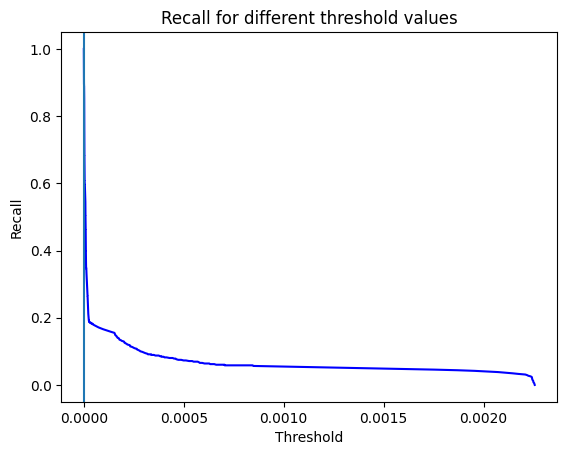

In [79]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.axvline(best_thresh)
plt.title('Recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.show()

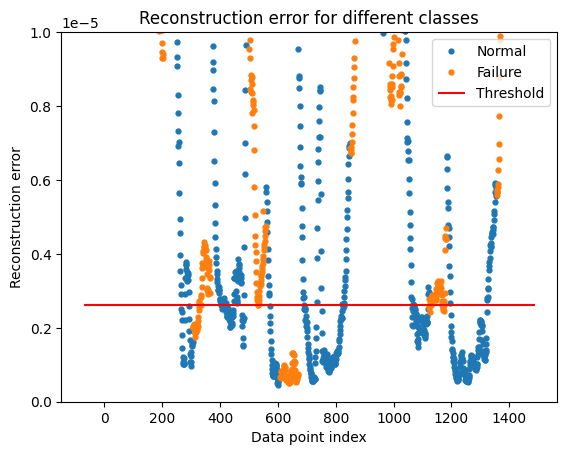

In [88]:
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Failure" if name == 1 else "Normal")
ax.hlines(best_thresh, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.ylim(0, 0.00001)
plt.show();

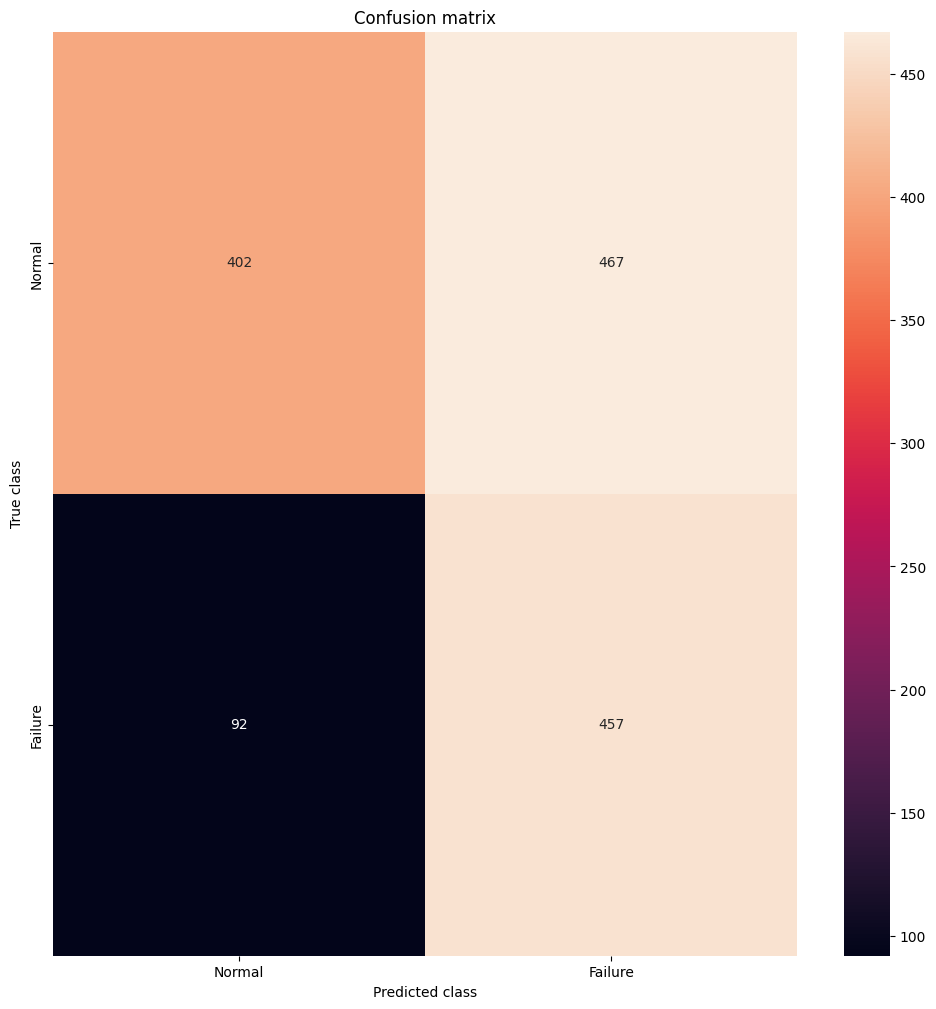

In [83]:
LABELS = ["Normal", "Failure"]
y_pred = [1 if e > best_thresh else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()